## LightGBM
就GBDT系列算法的性能而言，XGBoost已经非常高效了，但并非没有缺陷。LightGBM就是一种针对XGBoost缺陷的改进版本，**使得GBDT算法系统更轻便、更高效，能够做到又快又准**。本章针对XGBoost可优化的地方，引出LightGBM的基本原理，包括`直方图算法`、`单边梯度抽样`、`互斥特征捆绑算法`以及`leaf-wise生长策略`。

### 1 XGBoost可优化的地方
`XGBoost`通过预排序的算法来寻找特征的最优分裂点，虽然预排序算法能够准确找出特征的分裂点，但该方法占用空间太大，在数据量和特征量都比较多的情况下，会严重影响算法性能。`XGBoost`寻找最优分裂点的算法复杂度可以估计为：   
$$ 复杂度=特征数\times 特征分裂点的数量\times 样本量 $$
既然`XGBoost`的复杂度是由`特征数`、`特征分裂点的数量`和`样本量`决定的，`LightGBM`的优化方向也是从这三个方向考虑的。

### 2 LightGBM基本原理
`LightGBM`全称为`light gradient boosting machine`（轻量的梯度提升机），是由微软于2017年开源的一款顶级Boosting算法框架。跟XGBoost一样，LightGBM也是GBDT算法框架的一种工程实现，不过更快速、更高效。

#### 2.1 直方图算法
为了`减少特征分裂点数量和更加高效地寻找最优特征分裂点`，lightGBM不同于XGBoost的预排序算法，采用直方图算法寻找最优特征分裂点。其主要思路是将连续的浮点特征值离散化为k个整数并构造一个宽度为k的直方图。对每个特征数据进行遍历的时候，将离散化后的值用于索引作为直方图的累计统计量。遍历完一次后直方图便可积累对应的统计量，然后根据该直方图寻找最优分裂点。

直方图的本质是一种数据离散化和分箱操作，虽然谈不上特别新颖的优化设计，但确实速度快性能优，计算代价和内存占用都大大减少。   

直方图的另一个好处在于差加速。一个叶子结点的直方图可由其父结点的直方图与其兄弟结点的直方图做差得到，这也可以加速特征结点分裂。

#### 2.2 单边梯度抽样
`单边梯度抽样`（`gradient-based one-side sampling, GOSS`）算法是`LightGBM`从**减少样本的角度**进行优化而设计的算法，是`LightGBM`的核心原理之一。     

单边梯度抽样算法的主要思路是从减少样本的角度出发，将训练过程中大部分权重较小的样本剔除，仅对剩余样本数据计算信息增益。   

在`chapter10`中的`AdaBoost`算法中，该算法的一个关键要素是样本权重，通过在训练过程中不断调整样本分类权重从而达到最优分类效果。但在`GBDT`系列中并没有样本权重的相关设计，`GBDT`采用样本梯度来代替权重的概念。一般来说，训练梯度小的样本，其经验误差也小，说明这部分数据已经获得了较好的训练，`GBDT`的想法是在下一步的残差拟合中丢弃这部分样本，但这样做可能会改变训练样本的数据分布，影响最终的训练精度。

`LightGBM`提出采用`GOSS采样算法`，其目的是尽可能保留对计算信息增益有帮助的样本，提高模型训练速度。`GOSS`的基本做法是先将需要进行分裂的特征按照绝对值大小降序进行排序，取绝对值最大的前`a%`个数据，假设样本大小为`n`，在剩下的`(1-a)%`个数据中随机选择`b%`个数据，将这`b%`个数据乘以一个常数`(1-a)/b`：将小梯度样本乘上一个权重系数，将样本分布尽可能拉回来。这种做法会使得算法更加专注于训练不够充分的样本，并且原始的数据分布不会有太大改变。最后使用`a+b`个数据来计算该特征的信息增益。    

`GOSS`算法主要从减少样本的角度来对`GBDT`进行优化。丢弃梯度较小的样本并且在不损失太多精度的情况下提升模型训练速度，这是`LightGBM`速度较快的原因之一。

#### 2.3 互斥特征捆绑算法
直方图算法对应特征分裂点的优化，单边梯度抽样对应样本量的优化，最后还剩特征数的优化。   

`互斥特征捆绑`(`exclusive feature bunding, EFB`)算法通过将两个互斥的特征捆绑为一个特征，在不丢失特征信息的前提下，减少特征数，从而加速模型训练。大多数时候两个特征不是完全互斥的，可以用定义一个冲突比率衡量特征不互斥程度，当冲突比率较低时，可以将不完全互斥的两个特征捆绑，这对最后模型精度没有太大影响。    

所谓`特征互斥`，即**两个特征不会同时为非零值**，这一点跟分类特征的`one-hot`表达有点类似。互斥特征捆绑算法的关键问题有两个：一个是如何判断将哪些特征进行捆绑，另一个是如何将特征进行绑定，即绑定后的特征如何取值。    

针对第一个问题，EFB算法将其转化为`图着色问题`(`graph coloring problem`)来求解。其基本思路是将所有特征看作图中各个顶点，用一条边连接不互相独立的两个特征，边的权重则表示两个相连接的特征的冲突比率，需要绑定在一起的特征就是图着色问题中要涂上同一种颜色的点（特征）。   

第二个问题是要确定绑定后的特征如何进行取值，其关键在于能够将原始特征从合并后的特征中分离，即绑定到一个特征后，我们仍然能够从这个绑定的`bundle`中识别出原始特征。`EFB算法`针对该问题尝试从直方图的角度来处理，具体做法是将不同特征值分到绑定的`bundle`中不同的直方图中，通过在特征值中加一个偏置常量来处理。   

举一个简单的例子，假设我们要绑定的特征A和特征B两个特征，特征A的取值范围为[10,20)，特征B的取值范围是[10, 30)， 我们可以给特征B的取值范围加一个偏置量10，则特征B的取值范围变成了[20, 40)，绑定后的特征取值范围变成了[10,40)，这样特征A和特征B就可以融合了。

#### 2.4 leaf-wise生长策略
`LightGBM`还提出了区别于`XGBoost`的按层生长的叶子结点生长方式，即带有深度限制的按叶子结点(`leaf-wise`)生长的决策树生长方法。   

`XGBoost`按层生长的`level-wise`算法，好处是可以多线程优化，也方便控制模型复杂度，且不易过拟合，缺点是不加区分地对待同一层所有叶子结点，大部分节点分裂和增益计算不是必须的，产生了额外的计算开销。   

`LightGBM`提出按叶子结点生长地`leaf-wise`算法，精度更高且更高效，能够节约不必要的计算开销，同时为了防止某一结点过分生长而加上一个深度限制机制，能够保证在保证精度的同时一定程度上防止过拟合。   

除以上四点改进算法外，LightGBM在工程实现上也有一些改进和优化，比如可以直接支持类别特征（不需要在对类别特征进行one-hot处理）、高效并行和cache(命中)命中率优化等。

### 3 LightGBM原生库示例
开源`LightGBM`项目的微软开发团队提供了该算法的原生库实现，`lightgbm库`提供了`分类`和`回归`两大接口，下面以分类问题和`iris数据集`为例给出原生`lightgbm`接口的一个示例。

[1]	valid_0's multi_logloss: 1.02277
[2]	valid_0's multi_logloss: 0.943765
[3]	valid_0's multi_logloss: 0.873274
[4]	valid_0's multi_logloss: 0.810478
[5]	valid_0's multi_logloss: 0.752973
[6]	valid_0's multi_logloss: 0.701621
[7]	valid_0's multi_logloss: 0.654982
[8]	valid_0's multi_logloss: 0.611268
[9]	valid_0's multi_logloss: 0.572202
[10]	valid_0's multi_logloss: 0.53541
[11]	valid_0's multi_logloss: 0.502582
[12]	valid_0's multi_logloss: 0.472856
[13]	valid_0's multi_logloss: 0.443853
[14]	valid_0's multi_logloss: 0.417764
[15]	valid_0's multi_logloss: 0.393613
[16]	valid_0's multi_logloss: 0.370679
[17]	valid_0's multi_logloss: 0.349936
[18]	valid_0's multi_logloss: 0.330669
[19]	valid_0's multi_logloss: 0.312805
[20]	valid_0's multi_logloss: 0.296973
1.0


d:\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


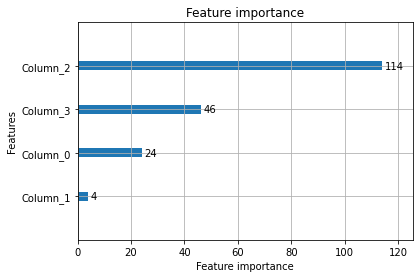

In [1]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

iris = load_iris()
data, target = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=43)
gbm = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    num_leaves=31, # 控制每个决策树中叶子节点的数量，也就是决策树的复杂度
    learning_rate=0.05,
    n_estimators=20
)

gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print(accuracy_score(y_pred, y_test))
lgb.plot_importance(gbm)
plt.show()